In [12]:
# Data manipulation
import pandas as pd
import numpy as np
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Metric and model form scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
# Boosting model
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
# Tuning optimization
import optuna
import optuna.visualization as vis
# System utilities
import warnings
warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dataset\.venv\Scripts\python.exe


#### The Dataset
###### First there is again the study on the old dataset

In [13]:
df = pd.read_csv("Datasets/Churn_clean.csv") # Data cleaning and feature engineering done in Feature_Engineering.ipynb
df['Imp_Liquidita_Attuale']=df['Imp_Liquidit�_Attuale']
df=df.drop(columns=['Imp_Liquidit�_Attuale'])
df.head()


,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Flag_Contatto_Call_Center,Flag_variazione_Accredito_Stipendio,Num_Punti_Programma_Loyalty,Imp_Gestito_attuale,Imp_Amministrato_attuale,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID,Imp_Liquidita_Attuale
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,1.0,0.0,NaN,2978.40,2980.92,0,0,0,0,1634.57
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,1.0,-1.0,325.0,NaN,34916.15,0,0,0,0,11918.26
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,1.0,0.0,460.0,NaN,232776.62,1,0,0,0,2671.95
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,0.0,-1.0,NaN,15013.53,15017.53,0,0,0,0,19211.31
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1.0,NaN,3650.0,NaN,NaN,0,0,0,0,1526.38


##### Preprocessing

In [14]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}).astype(int)
XX = pd.get_dummies(X) 

def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # Split 4:5, random state to ensure reproducibility

XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False)) #Encoding of the categorical features
X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index] #division in train and test

# apply clean_feature_names
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_train, X_test = X_train.align(X_test, join='inner', axis=1) #alignment of train and test columns, to ensure that they have the same lenght

X_train_final = X_train
X_test_final = X_test
y_train_final = y_train
y_test_final = y_test

LightGBM 

In [15]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

best_params = {
    "n_estimators": 218,
    "learning_rate": 0.01924315730262365,
    "max_depth": 14,
    "num_leaves": 39,
    "min_child_samples": 25,
    "subsample": 0.9614156550100574,
    "subsample_freq": 3,
    "colsample_bytree": 0.7963352256675209,
    "reg_alpha": 0.3944497642389667,
    "reg_lambda": 0.5504332251782049,
    "max_bin": 245,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train_final, y_train_final)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_final)[:, 1]



In [16]:
import xgboost

# There was a problem with the parameters verbosity, I had to set manually a value in range in main xgboost configuration
xgb.set_config(verbosity=0)
config = xgb.get_config()
assert config['verbosity'] == 0
xgboost.config_context(verbosity=0)
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgb_params = {
    'n_estimators': 779,
    'learning_rate': 0.05230683198500739,
    'max_depth': 3,
    'min_child_weight': 3,
    'subsample': 0.6723675387518698,
    'colsample_bytree': 0.8481282797708494,
    'gamma': 1.0748305640105353,
    'reg_alpha': 1.908194383169251,
    'reg_lambda': 5.262797824019152,
    'scale_pos_weight': scale_pos_weight,
}

best_xgb_classifier = xgb.XGBClassifier(verbosity=0, **xgb_params)
best_xgb_classifier.fit(X_train_final, y_train_final)
xgb_predictions = best_xgb_classifier.predict_proba(X_test_final)[:, 1]

Catboost

In [17]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

catboost_params = {
    'n_estimators': 329,
    'learning_rate': 0.05194348975504665,
    'max_depth': 14,
    'l2_leaf_reg': 7.9578314783147945,
    'border_count': 188,
    'grow_policy': 'Lossguide',
    'min_data_in_leaf': 29,
    'leaf_estimation_iterations': 6,
    'leaf_estimation_method': 'Gradient',
    'scale_pos_weight': scale_pos_weight,
}
best_catboost_classifier = cb.CatBoostClassifier(**catboost_params)
best_catboost_classifier.fit(X_train_final, y_train_final)
catboost_predictions = best_catboost_classifier.predict_proba(X_test_final)[:, 1]

0:	learn: 0.6791362	total: 204ms	remaining: 1m 6s
1:	learn: 0.6644259	total: 284ms	remaining: 46.4s
2:	learn: 0.6518304	total: 356ms	remaining: 38.6s
3:	learn: 0.6392397	total: 435ms	remaining: 35.3s
4:	learn: 0.6278169	total: 507ms	remaining: 32.9s
5:	learn: 0.6173551	total: 580ms	remaining: 31.2s
6:	learn: 0.6080943	total: 653ms	remaining: 30.1s
7:	learn: 0.5984151	total: 723ms	remaining: 29s
8:	learn: 0.5895983	total: 789ms	remaining: 28s
9:	learn: 0.5817696	total: 851ms	remaining: 27.2s
10:	learn: 0.5734568	total: 924ms	remaining: 26.7s
11:	learn: 0.5664548	total: 990ms	remaining: 26.2s
12:	learn: 0.5596290	total: 1.05s	remaining: 25.6s
13:	learn: 0.5534353	total: 1.12s	remaining: 25.2s
14:	learn: 0.5471563	total: 1.2s	remaining: 25.1s
15:	learn: 0.5416061	total: 1.27s	remaining: 24.9s
16:	learn: 0.5360527	total: 1.34s	remaining: 24.7s
17:	learn: 0.5307107	total: 1.46s	remaining: 25.2s
18:	learn: 0.5262139	total: 1.55s	remaining: 25.3s
19:	learn: 0.5215371	total: 1.65s	remaining: 2

Ensembling

In [18]:
# Manually set the weight
weight_catboost = 0.65
weight_xgb = 0.05
weight_lgbm = 0.3

In [19]:
catboost_pred = best_catboost_classifier.predict_proba(X_test_final)[:, 1]
xgb_pred = best_xgb_classifier.predict_proba(X_test_final)[:, 1]
lgbm_pred = best_lgb_classifier.predict_proba(X_test_final)[:, 1]

ensemble_predictions = (weight_catboost * catboost_predictions) + (weight_xgb * xgb_predictions) + (weight_lgbm * lgbm_predictions)

In [20]:
results_df = pd.DataFrame({
    'y_test': y_test_final,
    'y_pred_proba': ensemble_predictions

})
#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]
print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)
print("Numero di 'SI: nel nostro test set", count_ones)


Numero di 'SI' nei nostri 10k: 312
Numero di 'SI: nel nostro test set 393


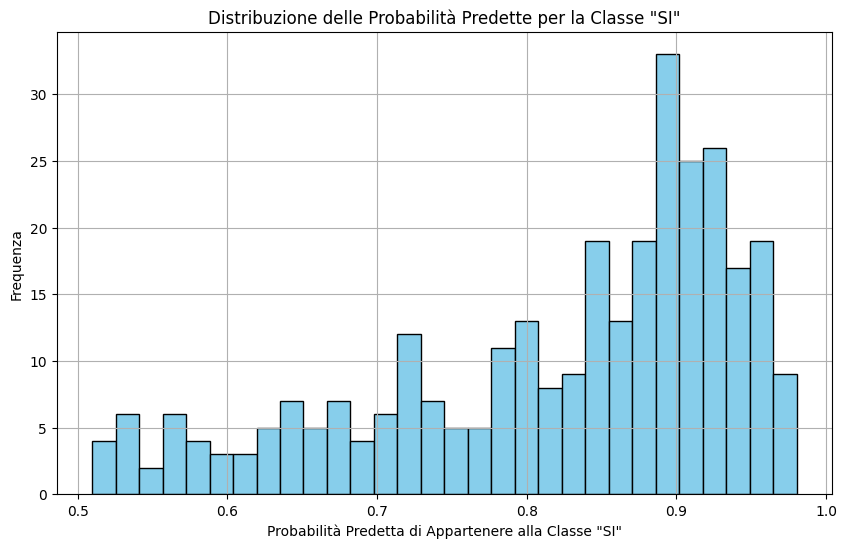

In [21]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

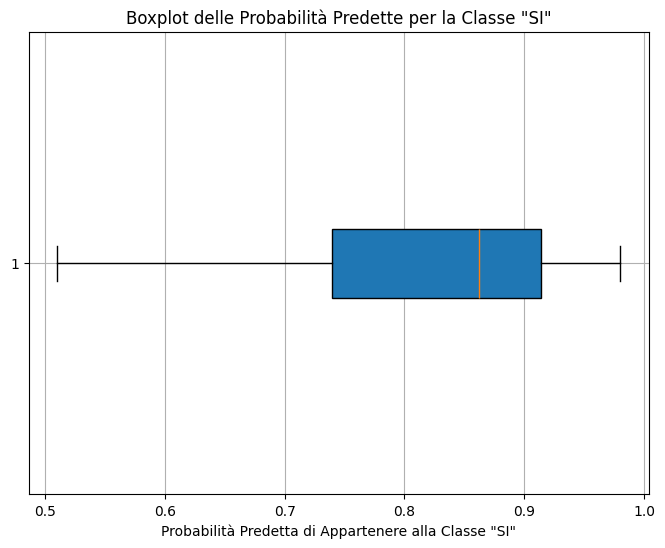

In [22]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

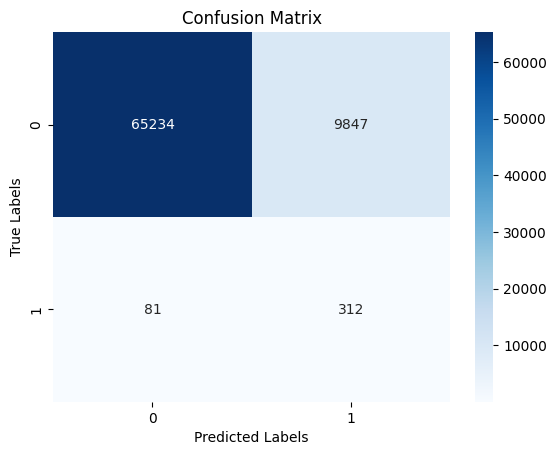

In [23]:
y_pred = (weight_catboost * catboost_pred) + (weight_xgb * xgb_pred) + (weight_lgbm * lgbm_pred)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_test_final, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
synthetic_df = pd.read_csv(r"Datasets\Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)

In [26]:
synthetic_df=synthetic_df
synthetic_df['Professione'] = synthetic_df['Professione'].apply(lambda x: 'Ufficiale/Sottoufficiale' if x == 'Ufficiale/Sottufficiale' else 
                                                                  'Libero professionista/Titolare impresa' if x == 'Libero professionista/Titolare di impresa' else 
                                                                  x)
synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('FO', 'FC')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('FO', 'FC')

synthetic_df['Provincia_Residenza'] = synthetic_df['Provincia_Residenza'].replace('PS', 'PU')
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('PS', 'PU')

synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('8N', np.nan)
synthetic_df['Provincia_Domicilio'] = synthetic_df['Provincia_Domicilio'].replace('BE', np.nan)
mapping = {
    'CAUTO': 1,
    'PRUDENTE': 2,
    'BILANCIATO': 3,
    'DINAMICO':4,
    'ND':0
}
synthetic_df['Profilo_MIFID'] = synthetic_df['Profilo_MIFID'].replace(mapping)

mapping2 = {
    'Bassissimo (<1200)': 1,
    'Basso (tra 1200 e 1500)': 2,
    'Medio (tra 1500 e 1800)': 3,
    'Alto (tra 1800 e 2500)':4,
    'Altissimo (>2500)':5
}

synthetic_df['Imp_Reddito'] = synthetic_df['Imp_Reddito'].replace(mapping2)


In [27]:
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  

In [28]:
X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)


Training features: (70000, 276)


In [29]:
# Rinomina le colonne per corrispondere esattamente a quelle utilizzate nell'addestramento
X_train_res_synthetic.columns = [col.replace(' ', '_') for col in X_train_res_synthetic.columns]

xgb_predictions_synt = best_xgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
lgbm_predictions_synt = best_lgb_classifier.predict_proba(X_train_res_synthetic)[:, 1]
catboost_predictions_synt = best_catboost_classifier.predict_proba(X_train_res_synthetic)[:, 1]
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': ensemble_predictions_synth

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_synthetic = results_df_si_sorted.head(10000)
print(top_10000_si_synthetic)

       y_test  y_pred_proba
18039       0      0.975197
26950       0      0.970565
34410       0      0.964254
67684       0      0.963013
48006       0      0.962752
...       ...           ...
9010        0      0.679470
47816       0      0.679466
41433       0      0.679441
14057       0      0.679386
61257       0      0.679374

[10000 rows x 2 columns]


In [30]:
count_si = top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 230
Numero di 'SI: nel nostro test set 489


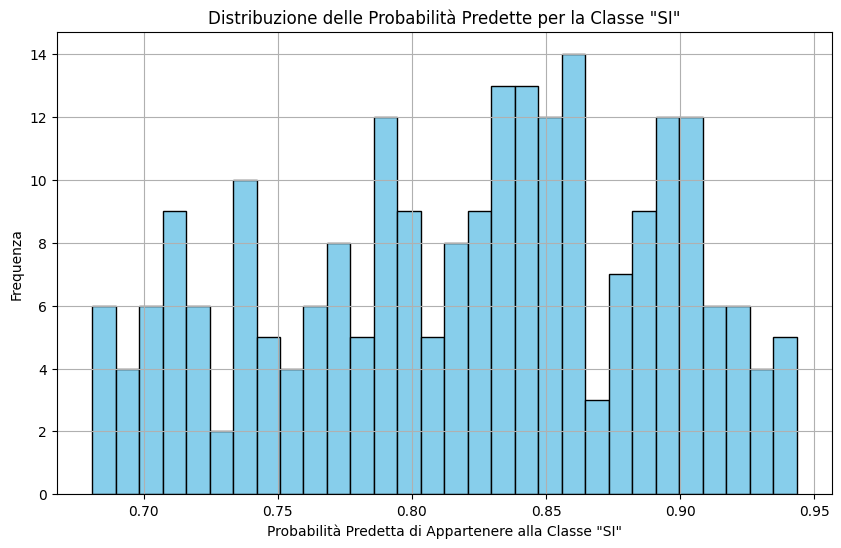

In [31]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si_synthetic[top_10000_si_synthetic['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

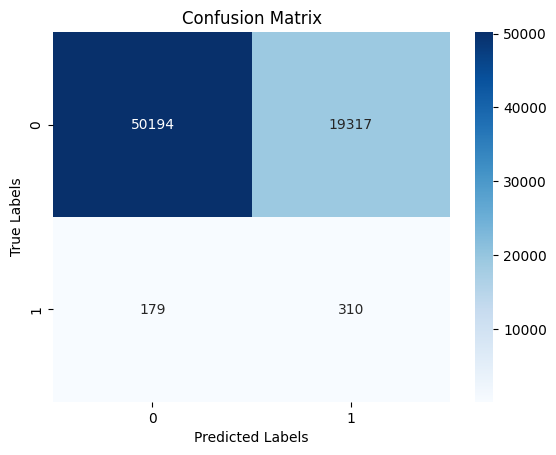

In [32]:
xgb_predictions_synt = best_xgb_classifier.predict(X_train_res_synthetic)
lgbm_predictions_synt = best_lgb_classifier.predict(X_train_res_synthetic)
catboost_predictions_synt = best_catboost_classifier.predict(X_train_res_synthetic)
ensemble_predictions_synth = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)

y_pred_binary = np.where(ensemble_predictions_synth > 0.5, 1, 0)

cm = confusion_matrix(y_synthetic, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Test Dataset

In [35]:
competition_df = pd.read_csv(r"Datasets/Churn_clean_competition.csv")


In [39]:
competition_df = pd.get_dummies(competition_df)
competition_df = clean_feature_names(competition_df)

missing_columns_train = set(XX.columns) - set(competition_df.columns)
for col in missing_columns_train:
    competition_df[col] = 0  

competition_df = competition_df[XX.columns]

print("Training features:", competition_df.shape)


Training features: (175331, 276)


In [40]:
# Rinomina le colonne per corrispondere esattamente a quelle utilizzate nell'addestramento
competition_df.columns = [col.replace(' ', '_') for col in competition_df.columns]

xgb_predictions_synt = best_xgb_classifier.predict_proba(competition_df)[:, 1]
lgbm_predictions_synt = best_lgb_classifier.predict_proba(competition_df)[:, 1]
catboost_predictions_synt = best_catboost_classifier.predict_proba(competition_df)[:, 1]
ensemble_predictions_comp = (weight_catboost * catboost_predictions_synt) + (weight_xgb* xgb_predictions_synt) + (weight_lgbm * lgbm_predictions_synt)


In [41]:
ensemble_predictions_comp

array([0.11610731, 0.19148298, 0.28333569, ..., 0.75864167, 0.34084313,
       0.92074589])

In [42]:
results_df = pd.DataFrame({
    'y_pred_proba': ensemble_predictions_comp

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
print(results_df_si_sorted)

        y_pred_proba
24143       0.984453
1457        0.983246
39130       0.983119
17856       0.983057
78985       0.982799
...              ...
102749      0.006127
63742       0.006058
77560       0.005824
55026       0.005809
168216      0.005473

[175331 rows x 1 columns]


###### Merging Id_cliente (that was removed before) and the 'si' results

In [44]:
df = pd.read_csv(r"Datasets/Churn_Banking_competition.csv", encoding='latin-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175331 entries, 0 to 175330
Data columns (total 42 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Id_Cliente                           175331 non-null  int64  
 1   Imp_Valore_del_Cliente               175329 non-null  float64
 2   Flag_Apertura_Conto_Online           175331 non-null  int64  
 3   Flag_Possesso_piu_Conti              175331 non-null  int64  
 4   Eta                                  175330 non-null  float64
 5   Provincia_Domicilio                  165351 non-null  object 
 6   Provincia_Residenza                  166140 non-null  object 
 7   Anno_Apertura_primo_Conto            175331 non-null  float64
 8   Professione                          158576 non-null  object 
 9   Imp_Reddito                          72783 non-null   object 
 10  Tipologia_Cliente                    175329 non-null  object 
 11  Sesso        

In [46]:
results_df_si_sorted['index_col'] = results_df_si_sorted.index
merged_df = pd.merge(df, results_df_si_sorted, left_index=True, right_on='index_col', how='left')
merged_df.drop(columns=['index_col'], inplace=True)
merged_df

,Id_Cliente,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Imp_Gestito_attuale,Imp_Amministrato_attuale,Imp_Liquidità_Attuale_6m,Imp_Gestito_attuale_6m,Imp_Amministrato_attuale_6m,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID,y_pred_proba
0,1,270.60,0,0,62.0,PG,PG,2009.0,Impiegato,Medio (tra 1500 e 1800),...,36100.96,71113.80,11727.24,5758.55,35921.63,0.0,0.0,0.0,0.0,0.116107
1,6,43.06,0,0,32.0,BO,BO,2010.0,Libero professionista/Titolare di impresa,Alto (tra 1800 e 2500),...,NaN,NaN,11841.45,NaN,NaN,0.0,0.0,0.0,0.0,0.191483
2,10,1445.58,0,0,68.0,LC,LC,2004.0,Libero professionista/Titolare di impresa,NaN,...,107818.19,107812.62,2824.91,73863.44,124177.12,0.0,0.0,0.0,0.0,0.283336
3,15,912.72,0,0,81.0,MN,MN,2007.0,Altro/Nessuno,NaN,...,54271.22,70986.43,963.22,51065.84,67278.10,0.0,0.0,0.0,0.0,0.385548
4,16,36.78,1,1,37.0,MI,MI,2009.0,Impiegato,NaN,...,NaN,NaN,3212.07,NaN,NaN,0.0,0.0,0.0,1.0,0.698270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175326,547425,4.54,0,0,41.0,MI,MI,2000.0,NaN,NaN,...,NaN,1288.60,1812.27,NaN,1539.38,0.0,0.0,0.0,0.0,0.424648
175327,547427,502.90,0,0,45.0,TO,TO,2006.0,Impiegato,Medio (tra 1500 e 1800),...,14930.62,14952.84,11344.66,15075.43,15075.44,0.0,0.0,0.0,0.0,0.115050
175328,547429,74.90,0,1,45.0,NaN,NaN,2006.0,Libero professionista/Titolare di impresa,NaN,...,NaN,527.80,4319.79,NaN,575.80,0.0,0.0,0.0,0.0,0.758642
175329,547431,0.57,0,0,40.0,TP,TP,2001.0,NaN,NaN,...,NaN,5.12,227.85,NaN,6.83,0.0,0.0,0.0,0.0,0.340843


In [47]:
sorted_df = merged_df.sort_values(by='y_pred_proba', ascending=False)
top_10000_si_comp = sorted_df.head(10000)
output_file_path = 'Top_10000_SI_Competition.xlsx'
top_10000_si_comp.to_excel(output_file_path, index=False, engine='openpyxl')


In [49]:
top_10000_si_comp.rename(columns={'y_pred_proba': 'score'}, inplace=True)
Top_10000_si= top_10000_si_comp[['Id_Cliente', 'score']]

output_file_path = 'Top_10000_SI_Competition.xlsx'
Top_10000_si.to_excel(output_file_path, index=False, engine='openpyxl')
